# Q-learning or Q-network (QN)

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0') # 200 total reward as goal
env = gym.make('CartPole-v1') # 500 total reward as goal

/home/arasdar/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
# env.reset()
# batch = []
# for _ in range(1000):
#     # env.render()
#     action = env.action_space.sample()
#     state, reward, done, info = env.step(action) # take a random action
#     batch.append([action, state, reward, done, info])
#     #print('state, action, reward, done, info:', state, action, reward, done, info)
#     if done:
#         env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
# batch[0], batch[0][1].shape

In [6]:
# actions = np.array([each[0] for each in batch])
# states = np.array([each[1] for each in batch])
# rewards = np.array([each[2] for each in batch])
# dones = np.array([each[3] for each in batch])
# infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
# print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
# print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
# print(np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
# print(np.max(np.array(rewards)), np.min(np.array(rewards)))
# print(np.max(np.array(states)), np.min(np.array(states)))

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [8]:
def model_input(state_size):
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return actions, states, targetQs

In [31]:
def actor(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('actor', reuse=reuse):
        # First fully connected layer
        #h1 = tf.layers.dense(inputs=states, units=hidden_size) # no weight init
        h1 = tf.contrib.layers.fully_connected(inputs=states, num_outputs=hidden_size, activation_fn=None)     
        bn1 = tf.layers.batch_norm(inputs=h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        #h2 = tf.layers.dense(inputs=nl1, units=hidden_size) # no weight init
        h2 = tf.contrib.layers.fully_connected(inputs=nl1, num_outputs=hidden_size, activation_fn=None)
        bn2 = tf.layers.batch_norm(inputs=h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        #logits = tf.layers.dense(inputs=nl2, units=action_size)
        logits = tf.layers.fully_connected(inputs=nl2, num_outputs=action_size, activation_fn=None)
        return logits

In [18]:
def model_loss(actions, states, targetQs, # model input
               action_size, hidden_size): # model init
    actions_logits = actor(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs = tf.reduce_max(actions_logits*actions_labels, axis=1)
    loss = tf.reduce_mean(tf.square(Qs - targetQs))
    return actions_logits, loss

In [19]:
def model_opt(loss, learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('actor')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [20]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs) # model input

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [21]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [22]:
# print('state size:{}'.format(states.shape), 
#       'actions:{}'.format(actions.shape)) 
# print('action size:', np.max(actions) - np.min(actions)+1)

In [23]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
action_size = 2
state_size = 4
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
gamma = 0.99                   # future reward discount

In [24]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [25]:
state = env.reset()
#for _ in range(batch_size):
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    state = next_state
    if done is True:
        state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [26]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list, loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        loss_batch = []
        state = env.reset()

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            total_reward += reward
            state = next_state

            # Training
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            next_actions_logits = sess.run(model.actions_logits, feed_dict = {model.states: next_states})
            nextQs = np.max(next_actions_logits, axis=1) * (1-dones)
            targetQs = rewards + (gamma * nextQs)
            loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.states: states, 
                                                                     model.actions: actions,
                                                                     model.targetQs: targetQs})
            loss_batch.append(loss)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{}'.format(total_reward),
              'loss:{:.4f}'.format(np.mean(loss_batch)),
              'exploreP:{:.4f}'.format(explore_p))
        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        loss_list.append([ep, np.mean(loss_batch)])
        # Break episode/epoch loop
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-qn.ckpt')

Episode:0 meanR:55.0000 R:55.0 loss:1.1167 exploreP:0.9946
Episode:1 meanR:54.5000 R:54.0 loss:1.3142 exploreP:0.9893
Episode:2 meanR:57.6667 R:64.0 loss:1.5115 exploreP:0.9830
Episode:3 meanR:46.7500 R:14.0 loss:1.4543 exploreP:0.9817
Episode:4 meanR:40.4000 R:15.0 loss:1.4796 exploreP:0.9802
Episode:5 meanR:35.8333 R:13.0 loss:1.6699 exploreP:0.9789
Episode:6 meanR:34.1429 R:24.0 loss:1.5968 exploreP:0.9766
Episode:7 meanR:32.8750 R:24.0 loss:1.6848 exploreP:0.9743
Episode:8 meanR:30.6667 R:13.0 loss:1.6625 exploreP:0.9730
Episode:9 meanR:30.0000 R:24.0 loss:1.7371 exploreP:0.9707
Episode:10 meanR:29.0000 R:19.0 loss:1.9785 exploreP:0.9689
Episode:11 meanR:28.3333 R:21.0 loss:1.9193 exploreP:0.9669
Episode:12 meanR:28.1538 R:26.0 loss:2.2627 exploreP:0.9644
Episode:13 meanR:28.5714 R:34.0 loss:2.2215 exploreP:0.9612
Episode:14 meanR:28.0000 R:20.0 loss:2.3071 exploreP:0.9593
Episode:15 meanR:26.9375 R:11.0 loss:2.8720 exploreP:0.9582
Episode:16 meanR:26.5294 R:20.0 loss:2.4597 explor

Episode:137 meanR:19.7400 R:66.0 loss:21.2493 exploreP:0.7519
Episode:138 meanR:19.8000 R:33.0 loss:16.2562 exploreP:0.7494
Episode:139 meanR:19.7600 R:19.0 loss:20.8372 exploreP:0.7480
Episode:140 meanR:19.8500 R:26.0 loss:23.8970 exploreP:0.7461
Episode:141 meanR:19.9100 R:15.0 loss:9.4020 exploreP:0.7450
Episode:142 meanR:19.9400 R:16.0 loss:18.7702 exploreP:0.7439
Episode:143 meanR:19.9500 R:19.0 loss:26.3100 exploreP:0.7425
Episode:144 meanR:19.9100 R:13.0 loss:21.5989 exploreP:0.7415
Episode:145 meanR:19.8500 R:14.0 loss:22.0396 exploreP:0.7405
Episode:146 meanR:19.8100 R:13.0 loss:13.1524 exploreP:0.7395
Episode:147 meanR:19.9200 R:24.0 loss:11.1391 exploreP:0.7378
Episode:148 meanR:19.8200 R:17.0 loss:12.4408 exploreP:0.7365
Episode:149 meanR:19.5200 R:13.0 loss:19.6287 exploreP:0.7356
Episode:150 meanR:19.3000 R:19.0 loss:14.8695 exploreP:0.7342
Episode:151 meanR:19.4200 R:21.0 loss:13.9880 exploreP:0.7327
Episode:152 meanR:19.4100 R:15.0 loss:19.2194 exploreP:0.7316
Episode:1

Episode:272 meanR:43.8800 R:86.0 loss:29.0222 exploreP:0.4527
Episode:273 meanR:44.1400 R:55.0 loss:31.2769 exploreP:0.4503
Episode:274 meanR:44.1200 R:20.0 loss:38.1608 exploreP:0.4494
Episode:275 meanR:43.6200 R:35.0 loss:35.1972 exploreP:0.4479
Episode:276 meanR:43.9800 R:53.0 loss:36.1672 exploreP:0.4455
Episode:277 meanR:44.2300 R:45.0 loss:34.0454 exploreP:0.4436
Episode:278 meanR:44.1200 R:27.0 loss:35.9515 exploreP:0.4424
Episode:279 meanR:44.6500 R:121.0 loss:29.6059 exploreP:0.4372
Episode:280 meanR:44.6200 R:40.0 loss:29.8355 exploreP:0.4355
Episode:281 meanR:44.6600 R:47.0 loss:21.9630 exploreP:0.4335
Episode:282 meanR:44.2800 R:28.0 loss:37.6655 exploreP:0.4323
Episode:283 meanR:44.3700 R:81.0 loss:27.9185 exploreP:0.4289
Episode:284 meanR:44.7300 R:96.0 loss:34.5479 exploreP:0.4249
Episode:285 meanR:44.5600 R:44.0 loss:34.7531 exploreP:0.4231
Episode:286 meanR:44.5100 R:66.0 loss:27.8440 exploreP:0.4204
Episode:287 meanR:44.4100 R:30.0 loss:28.9848 exploreP:0.4192
Episode

Episode:403 meanR:158.9500 R:251.0 loss:23.5112 exploreP:0.0871
Episode:404 meanR:162.3900 R:425.0 loss:27.8358 exploreP:0.0839
Episode:405 meanR:165.4400 R:352.0 loss:39.3714 exploreP:0.0813
Episode:406 meanR:168.5600 R:357.0 loss:75.9162 exploreP:0.0788
Episode:407 meanR:171.3300 R:380.0 loss:107.0366 exploreP:0.0763
Episode:408 meanR:174.9400 R:408.0 loss:137.5919 exploreP:0.0736
Episode:409 meanR:179.0500 R:460.0 loss:175.9118 exploreP:0.0708
Episode:410 meanR:183.3000 R:473.0 loss:219.9638 exploreP:0.0680
Episode:411 meanR:187.3000 R:500.0 loss:269.7329 exploreP:0.0651
Episode:412 meanR:191.8900 R:500.0 loss:284.4031 exploreP:0.0624
Episode:413 meanR:195.7100 R:500.0 loss:236.7557 exploreP:0.0599
Episode:414 meanR:197.9400 R:306.0 loss:132.8229 exploreP:0.0584
Episode:415 meanR:201.2200 R:426.0 loss:42.5592 exploreP:0.0564
Episode:416 meanR:203.2700 R:232.0 loss:21.3603 exploreP:0.0553
Episode:417 meanR:204.4200 R:230.0 loss:10.8307 exploreP:0.0543
Episode:418 meanR:206.0400 R:218

Episode:533 meanR:85.7700 R:107.0 loss:76.1727 exploreP:0.0243
Episode:534 meanR:85.8500 R:120.0 loss:115.5105 exploreP:0.0241
Episode:535 meanR:86.7400 R:126.0 loss:79.0642 exploreP:0.0240
Episode:536 meanR:86.9100 R:123.0 loss:89.6875 exploreP:0.0238
Episode:537 meanR:86.7400 R:87.0 loss:76.5412 exploreP:0.0237
Episode:538 meanR:86.5000 R:23.0 loss:134.2551 exploreP:0.0236
Episode:539 meanR:85.8900 R:30.0 loss:120.4717 exploreP:0.0236
Episode:540 meanR:85.8500 R:23.0 loss:154.8720 exploreP:0.0236
Episode:541 meanR:85.7100 R:21.0 loss:87.7739 exploreP:0.0235
Episode:542 meanR:85.5700 R:19.0 loss:62.8931 exploreP:0.0235
Episode:543 meanR:85.6000 R:25.0 loss:105.5813 exploreP:0.0235
Episode:544 meanR:85.6000 R:24.0 loss:117.3182 exploreP:0.0235
Episode:545 meanR:85.6800 R:28.0 loss:141.0336 exploreP:0.0234
Episode:546 meanR:85.6600 R:23.0 loss:111.7057 exploreP:0.0234
Episode:547 meanR:85.7300 R:23.0 loss:198.2166 exploreP:0.0234
Episode:548 meanR:85.7300 R:22.0 loss:83.5677 exploreP:0.

Episode:663 meanR:465.6200 R:412.0 loss:1.5855 exploreP:0.0101
Episode:664 meanR:465.5000 R:488.0 loss:1.4469 exploreP:0.0101
Episode:665 meanR:465.5000 R:500.0 loss:1.2763 exploreP:0.0101
Episode:666 meanR:465.5000 R:500.0 loss:1.7472 exploreP:0.0101
Episode:667 meanR:465.0600 R:456.0 loss:1.4206 exploreP:0.0101
Episode:668 meanR:464.8800 R:482.0 loss:1.1822 exploreP:0.0101
Episode:669 meanR:463.9600 R:408.0 loss:1.6886 exploreP:0.0101
Episode:670 meanR:463.9600 R:500.0 loss:0.7306 exploreP:0.0101
Episode:671 meanR:463.9600 R:500.0 loss:1.4828 exploreP:0.0101
Episode:672 meanR:463.7500 R:479.0 loss:1.6627 exploreP:0.0101
Episode:673 meanR:463.7500 R:500.0 loss:0.7898 exploreP:0.0101
Episode:674 meanR:463.7500 R:500.0 loss:0.9619 exploreP:0.0101
Episode:675 meanR:463.7500 R:500.0 loss:1.0036 exploreP:0.0101
Episode:676 meanR:464.9500 R:443.0 loss:1.0649 exploreP:0.0101
Episode:677 meanR:465.3200 R:412.0 loss:1.6192 exploreP:0.0101
Episode:678 meanR:466.3600 R:464.0 loss:0.9956 exploreP

Episode:794 meanR:454.0300 R:9.0 loss:24.5124 exploreP:0.0100
Episode:795 meanR:449.1300 R:10.0 loss:26.9756 exploreP:0.0100
Episode:796 meanR:444.2200 R:9.0 loss:353.2047 exploreP:0.0100
Episode:797 meanR:439.3100 R:9.0 loss:783.4241 exploreP:0.0100
Episode:798 meanR:434.4100 R:10.0 loss:33.3336 exploreP:0.0100
Episode:799 meanR:429.4900 R:8.0 loss:33.8710 exploreP:0.0100
Episode:800 meanR:424.5800 R:9.0 loss:509.8400 exploreP:0.0100
Episode:801 meanR:419.6600 R:8.0 loss:45.8607 exploreP:0.0100
Episode:802 meanR:414.7600 R:10.0 loss:46.7659 exploreP:0.0100
Episode:803 meanR:409.8600 R:10.0 loss:516.1448 exploreP:0.0100
Episode:804 meanR:404.9600 R:10.0 loss:631.4713 exploreP:0.0100
Episode:805 meanR:400.0600 R:10.0 loss:83.3044 exploreP:0.0100
Episode:806 meanR:395.1500 R:9.0 loss:2962.5647 exploreP:0.0100
Episode:807 meanR:390.2500 R:10.0 loss:919.0884 exploreP:0.0100
Episode:808 meanR:385.3500 R:10.0 loss:77.0812 exploreP:0.0100
Episode:809 meanR:380.6100 R:11.0 loss:652.3281 explor

Episode:931 meanR:13.8800 R:11.0 loss:1158.8892 exploreP:0.0100
Episode:932 meanR:13.8800 R:10.0 loss:573.4874 exploreP:0.0100
Episode:933 meanR:13.8900 R:11.0 loss:1266.1216 exploreP:0.0100
Episode:934 meanR:13.8900 R:10.0 loss:797.5944 exploreP:0.0100
Episode:935 meanR:13.9300 R:12.0 loss:1166.4963 exploreP:0.0100
Episode:936 meanR:13.9400 R:11.0 loss:328.5138 exploreP:0.0100
Episode:937 meanR:13.9500 R:13.0 loss:102.0039 exploreP:0.0100
Episode:938 meanR:13.9500 R:11.0 loss:1917.6356 exploreP:0.0100
Episode:939 meanR:13.9600 R:11.0 loss:313.3032 exploreP:0.0100
Episode:940 meanR:13.9500 R:13.0 loss:906.8425 exploreP:0.0100
Episode:941 meanR:13.9200 R:12.0 loss:652.2918 exploreP:0.0100
Episode:942 meanR:13.8800 R:12.0 loss:1713.5616 exploreP:0.0100
Episode:943 meanR:9.6500 R:13.0 loss:498.4207 exploreP:0.0100
Episode:944 meanR:9.7300 R:17.0 loss:613.8254 exploreP:0.0100
Episode:945 meanR:9.8300 R:20.0 loss:746.2155 exploreP:0.0100
Episode:946 meanR:11.7500 R:203.0 loss:541.5153 explo

Episode:1060 meanR:421.3900 R:334.0 loss:0.1353 exploreP:0.0100
Episode:1061 meanR:421.1600 R:351.0 loss:0.1701 exploreP:0.0100
Episode:1062 meanR:419.8600 R:370.0 loss:0.1182 exploreP:0.0100
Episode:1063 meanR:418.3700 R:351.0 loss:0.1300 exploreP:0.0100
Episode:1064 meanR:417.4700 R:322.0 loss:0.1114 exploreP:0.0100
Episode:1065 meanR:415.8600 R:339.0 loss:0.1196 exploreP:0.0100
Episode:1066 meanR:416.1600 R:414.0 loss:0.1150 exploreP:0.0100
Episode:1067 meanR:416.5100 R:387.0 loss:0.1080 exploreP:0.0100
Episode:1068 meanR:415.7800 R:427.0 loss:0.1634 exploreP:0.0100
Episode:1069 meanR:414.3500 R:357.0 loss:0.1168 exploreP:0.0100
Episode:1070 meanR:413.6400 R:390.0 loss:0.1181 exploreP:0.0100
Episode:1071 meanR:412.4400 R:380.0 loss:0.1359 exploreP:0.0100
Episode:1072 meanR:411.3500 R:391.0 loss:0.0845 exploreP:0.0100
Episode:1073 meanR:410.4600 R:411.0 loss:0.0924 exploreP:0.0100
Episode:1074 meanR:408.9100 R:345.0 loss:0.0958 exploreP:0.0100
Episode:1075 meanR:408.3600 R:445.0 loss

Episode:1188 meanR:494.5400 R:500.0 loss:7.9393 exploreP:0.0100
Episode:1189 meanR:494.5400 R:500.0 loss:12.0642 exploreP:0.0100
Episode:1190 meanR:494.6700 R:500.0 loss:11.0751 exploreP:0.0100
Episode:1191 meanR:494.6700 R:500.0 loss:10.9282 exploreP:0.0100
Episode:1192 meanR:495.3800 R:500.0 loss:11.1487 exploreP:0.0100
Episode:1193 meanR:495.3800 R:500.0 loss:7.1010 exploreP:0.0100
Episode:1194 meanR:495.5200 R:500.0 loss:12.6560 exploreP:0.0100
Episode:1195 meanR:496.2900 R:500.0 loss:6.7184 exploreP:0.0100
Episode:1196 meanR:496.2900 R:500.0 loss:8.1789 exploreP:0.0100
Episode:1197 meanR:497.1100 R:500.0 loss:8.7689 exploreP:0.0100
Episode:1198 meanR:497.1100 R:500.0 loss:8.8245 exploreP:0.0100
Episode:1199 meanR:497.1100 R:500.0 loss:5.8767 exploreP:0.0100
Episode:1200 meanR:497.1100 R:500.0 loss:8.4030 exploreP:0.0100
Episode:1201 meanR:497.1100 R:500.0 loss:5.6734 exploreP:0.0100
Episode:1202 meanR:497.1100 R:500.0 loss:7.0130 exploreP:0.0100
Episode:1203 meanR:497.1100 R:500.0

Episode:1316 meanR:491.5900 R:430.0 loss:2.7131 exploreP:0.0100
Episode:1317 meanR:491.1500 R:418.0 loss:4.3955 exploreP:0.0100
Episode:1318 meanR:490.8000 R:465.0 loss:4.8910 exploreP:0.0100
Episode:1319 meanR:490.6400 R:484.0 loss:4.1306 exploreP:0.0100
Episode:1320 meanR:489.6300 R:399.0 loss:4.2109 exploreP:0.0100
Episode:1321 meanR:488.2700 R:364.0 loss:4.9459 exploreP:0.0100
Episode:1322 meanR:487.6100 R:434.0 loss:2.4258 exploreP:0.0100
Episode:1323 meanR:487.4700 R:486.0 loss:3.2181 exploreP:0.0100
Episode:1324 meanR:487.4700 R:500.0 loss:1.8890 exploreP:0.0100
Episode:1325 meanR:487.4700 R:500.0 loss:2.1412 exploreP:0.0100
Episode:1326 meanR:487.4700 R:500.0 loss:2.9198 exploreP:0.0100
Episode:1327 meanR:487.3400 R:487.0 loss:7.0965 exploreP:0.0100
Episode:1328 meanR:486.8900 R:455.0 loss:11.7595 exploreP:0.0100
Episode:1329 meanR:484.4100 R:252.0 loss:8.9622 exploreP:0.0100
Episode:1330 meanR:481.9900 R:258.0 loss:7.7492 exploreP:0.0100
Episode:1331 meanR:479.8700 R:288.0 los

Episode:1448 meanR:47.9500 R:10.0 loss:234.2637 exploreP:0.0100
Episode:1449 meanR:44.3800 R:10.0 loss:108.3129 exploreP:0.0100
Episode:1450 meanR:41.7100 R:10.0 loss:56.7439 exploreP:0.0100
Episode:1451 meanR:39.1500 R:9.0 loss:45.7125 exploreP:0.0100
Episode:1452 meanR:37.2900 R:9.0 loss:155.9766 exploreP:0.0100
Episode:1453 meanR:35.3300 R:10.0 loss:64.5979 exploreP:0.0100
Episode:1454 meanR:33.6300 R:10.0 loss:151.6491 exploreP:0.0100
Episode:1455 meanR:31.6400 R:9.0 loss:139.8976 exploreP:0.0100
Episode:1456 meanR:29.4100 R:11.0 loss:53.1340 exploreP:0.0100
Episode:1457 meanR:24.5200 R:11.0 loss:221.5028 exploreP:0.0100
Episode:1458 meanR:29.4100 R:500.0 loss:54.2365 exploreP:0.0100
Episode:1459 meanR:32.1600 R:284.0 loss:32.3317 exploreP:0.0100
Episode:1460 meanR:34.5100 R:246.0 loss:31.4050 exploreP:0.0100
Episode:1461 meanR:36.7000 R:230.0 loss:33.3066 exploreP:0.0100
Episode:1462 meanR:38.7300 R:213.0 loss:34.0948 exploreP:0.0100
Episode:1463 meanR:40.7800 R:215.0 loss:26.4195

Episode:1574 meanR:427.5900 R:500.0 loss:8.8030 exploreP:0.0100
Episode:1575 meanR:426.0700 R:348.0 loss:11.9117 exploreP:0.0100
Episode:1576 meanR:426.0700 R:500.0 loss:7.1005 exploreP:0.0100
Episode:1577 meanR:427.5000 R:500.0 loss:9.2520 exploreP:0.0100
Episode:1578 meanR:426.1500 R:365.0 loss:10.5515 exploreP:0.0100
Episode:1579 meanR:427.9200 R:500.0 loss:9.0753 exploreP:0.0100
Episode:1580 meanR:427.2500 R:433.0 loss:11.2414 exploreP:0.0100
Episode:1581 meanR:427.6900 R:500.0 loss:8.3403 exploreP:0.0100
Episode:1582 meanR:429.4300 R:500.0 loss:5.7089 exploreP:0.0100
Episode:1583 meanR:430.6800 R:500.0 loss:9.2085 exploreP:0.0100
Episode:1584 meanR:432.1800 R:500.0 loss:13.3540 exploreP:0.0100
Episode:1585 meanR:434.1800 R:500.0 loss:9.5930 exploreP:0.0100
Episode:1586 meanR:435.0400 R:370.0 loss:7.3247 exploreP:0.0100
Episode:1587 meanR:437.0200 R:500.0 loss:2.0972 exploreP:0.0100
Episode:1588 meanR:439.6400 R:500.0 loss:11.4720 exploreP:0.0100
Episode:1589 meanR:442.1900 R:500.0

Episode:1701 meanR:495.9000 R:500.0 loss:16.8773 exploreP:0.0100
Episode:1702 meanR:495.9000 R:500.0 loss:15.9410 exploreP:0.0100
Episode:1703 meanR:495.9000 R:500.0 loss:16.0557 exploreP:0.0100
Episode:1704 meanR:495.9000 R:500.0 loss:18.4863 exploreP:0.0100
Episode:1705 meanR:495.9000 R:500.0 loss:10.0472 exploreP:0.0100
Episode:1706 meanR:495.9000 R:500.0 loss:16.8021 exploreP:0.0100
Episode:1707 meanR:495.9000 R:500.0 loss:14.4248 exploreP:0.0100
Episode:1708 meanR:495.9000 R:500.0 loss:17.6363 exploreP:0.0100
Episode:1709 meanR:495.9000 R:500.0 loss:18.8962 exploreP:0.0100
Episode:1710 meanR:495.4800 R:458.0 loss:17.0369 exploreP:0.0100
Episode:1711 meanR:495.4800 R:500.0 loss:17.8557 exploreP:0.0100
Episode:1712 meanR:495.4800 R:500.0 loss:15.5614 exploreP:0.0100
Episode:1713 meanR:495.4800 R:500.0 loss:14.9504 exploreP:0.0100
Episode:1714 meanR:495.4800 R:500.0 loss:14.4292 exploreP:0.0100
Episode:1715 meanR:495.3100 R:483.0 loss:17.0324 exploreP:0.0100
Episode:1716 meanR:495.31

Episode:1828 meanR:237.8100 R:500.0 loss:384.8126 exploreP:0.0100
Episode:1829 meanR:239.1300 R:500.0 loss:696.6644 exploreP:0.0100
Episode:1830 meanR:240.9700 R:500.0 loss:1243.4673 exploreP:0.0100
Episode:1831 meanR:242.5200 R:498.0 loss:1653.3571 exploreP:0.0100
Episode:1832 meanR:242.0400 R:309.0 loss:1961.1783 exploreP:0.0100
Episode:1833 meanR:240.3600 R:332.0 loss:2101.6411 exploreP:0.0100
Episode:1834 meanR:238.0700 R:228.0 loss:2230.3662 exploreP:0.0100
Episode:1835 meanR:235.8400 R:277.0 loss:2487.8259 exploreP:0.0100
Episode:1836 meanR:233.7300 R:289.0 loss:2854.7395 exploreP:0.0100
Episode:1837 meanR:232.9500 R:422.0 loss:2997.4751 exploreP:0.0100
Episode:1838 meanR:232.9500 R:500.0 loss:3174.1838 exploreP:0.0100
Episode:1839 meanR:232.9300 R:498.0 loss:3449.1997 exploreP:0.0100
Episode:1840 meanR:232.1500 R:422.0 loss:3759.8630 exploreP:0.0100
Episode:1841 meanR:229.0800 R:193.0 loss:3923.6614 exploreP:0.0100
Episode:1842 meanR:229.0800 R:500.0 loss:4260.6870 exploreP:0.01

Episode:1957 meanR:272.4200 R:9.0 loss:20.4482 exploreP:0.0100
Episode:1958 meanR:269.4600 R:11.0 loss:491.7393 exploreP:0.0100
Episode:1959 meanR:266.0100 R:10.0 loss:17.9870 exploreP:0.0100
Episode:1960 meanR:261.8700 R:9.0 loss:10.7213 exploreP:0.0100
Episode:1961 meanR:262.8500 R:500.0 loss:259.4211 exploreP:0.0100
Episode:1962 meanR:258.7800 R:93.0 loss:154.3128 exploreP:0.0100
Episode:1963 meanR:255.2700 R:91.0 loss:253.5130 exploreP:0.0100
Episode:1964 meanR:253.0600 R:80.0 loss:157.9511 exploreP:0.0100
Episode:1965 meanR:250.3900 R:79.0 loss:266.3269 exploreP:0.0100
Episode:1966 meanR:248.3100 R:76.0 loss:256.2301 exploreP:0.0100
Episode:1967 meanR:244.0000 R:69.0 loss:227.2855 exploreP:0.0100
Episode:1968 meanR:239.6700 R:67.0 loss:219.6413 exploreP:0.0100
Episode:1969 meanR:236.6200 R:54.0 loss:235.4321 exploreP:0.0100
Episode:1970 meanR:233.0300 R:52.0 loss:248.2299 exploreP:0.0100
Episode:1971 meanR:230.1200 R:40.0 loss:208.9108 exploreP:0.0100
Episode:1972 meanR:225.4800 R

Episode:2082 meanR:349.3700 R:500.0 loss:13.8245 exploreP:0.0100
Episode:2083 meanR:354.2600 R:500.0 loss:14.8501 exploreP:0.0100
Episode:2084 meanR:359.0800 R:500.0 loss:13.1685 exploreP:0.0100
Episode:2085 meanR:363.9600 R:500.0 loss:20.4234 exploreP:0.0100
Episode:2086 meanR:368.8500 R:500.0 loss:14.5221 exploreP:0.0100
Episode:2087 meanR:373.7300 R:500.0 loss:27.9660 exploreP:0.0100
Episode:2088 meanR:378.2300 R:500.0 loss:30.7206 exploreP:0.0100
Episode:2089 meanR:382.8200 R:500.0 loss:15.9456 exploreP:0.0100
Episode:2090 meanR:387.0400 R:500.0 loss:12.6809 exploreP:0.0100
Episode:2091 meanR:390.9300 R:500.0 loss:14.3009 exploreP:0.0100
Episode:2092 meanR:394.7800 R:500.0 loss:18.8233 exploreP:0.0100
Episode:2093 meanR:398.5600 R:500.0 loss:19.4637 exploreP:0.0100
Episode:2094 meanR:397.7700 R:48.0 loss:34.4170 exploreP:0.0100
Episode:2095 meanR:399.5600 R:310.0 loss:11.3097 exploreP:0.0100
Episode:2096 meanR:400.6600 R:285.0 loss:11.9078 exploreP:0.0100
Episode:2097 meanR:400.660

Episode:2209 meanR:495.5600 R:500.0 loss:26.4396 exploreP:0.0100
Episode:2210 meanR:495.5600 R:500.0 loss:18.8557 exploreP:0.0100
Episode:2211 meanR:495.5600 R:500.0 loss:17.7543 exploreP:0.0100
Episode:2212 meanR:495.5600 R:500.0 loss:23.5095 exploreP:0.0100
Episode:2213 meanR:495.5600 R:500.0 loss:19.2105 exploreP:0.0100
Episode:2214 meanR:495.5600 R:500.0 loss:18.6882 exploreP:0.0100
Episode:2215 meanR:495.5600 R:500.0 loss:13.8812 exploreP:0.0100
Episode:2216 meanR:495.5600 R:500.0 loss:13.4911 exploreP:0.0100
Episode:2217 meanR:495.5600 R:500.0 loss:14.8798 exploreP:0.0100
Episode:2218 meanR:495.5600 R:500.0 loss:11.7164 exploreP:0.0100
Episode:2219 meanR:495.5600 R:500.0 loss:15.7863 exploreP:0.0100
Episode:2220 meanR:495.5600 R:500.0 loss:17.6757 exploreP:0.0100
Episode:2221 meanR:495.5600 R:500.0 loss:8.7490 exploreP:0.0100
Episode:2222 meanR:495.5600 R:500.0 loss:14.1585 exploreP:0.0100
Episode:2223 meanR:495.5600 R:500.0 loss:9.3730 exploreP:0.0100
Episode:2224 meanR:495.5600

Episode:2336 meanR:248.2400 R:10.0 loss:251.0873 exploreP:0.0100
Episode:2337 meanR:243.3700 R:13.0 loss:27.1759 exploreP:0.0100
Episode:2338 meanR:238.4700 R:10.0 loss:248.7822 exploreP:0.0100
Episode:2339 meanR:233.5700 R:10.0 loss:205.7756 exploreP:0.0100
Episode:2340 meanR:228.6900 R:12.0 loss:665.5015 exploreP:0.0100
Episode:2341 meanR:228.6900 R:500.0 loss:163.0202 exploreP:0.0100
Episode:2342 meanR:232.3400 R:500.0 loss:148.7124 exploreP:0.0100
Episode:2343 meanR:232.3400 R:500.0 loss:224.7808 exploreP:0.0100
Episode:2344 meanR:232.3400 R:500.0 loss:281.3209 exploreP:0.0100
Episode:2345 meanR:232.3400 R:500.0 loss:364.6451 exploreP:0.0100
Episode:2346 meanR:232.3400 R:500.0 loss:524.6940 exploreP:0.0100
Episode:2347 meanR:232.3400 R:500.0 loss:750.7927 exploreP:0.0100
Episode:2348 meanR:232.3400 R:500.0 loss:1021.0762 exploreP:0.0100
Episode:2349 meanR:232.3400 R:500.0 loss:1171.4540 exploreP:0.0100
Episode:2350 meanR:232.3400 R:500.0 loss:1280.9465 exploreP:0.0100
Episode:2351 

Episode:2458 meanR:475.7000 R:500.0 loss:38012.8008 exploreP:0.0100
Episode:2459 meanR:475.7000 R:500.0 loss:41122.2227 exploreP:0.0100
Episode:2460 meanR:475.7000 R:500.0 loss:41156.6562 exploreP:0.0100
Episode:2461 meanR:475.7000 R:500.0 loss:41610.3125 exploreP:0.0100
Episode:2462 meanR:475.7000 R:500.0 loss:44131.2227 exploreP:0.0100
Episode:2463 meanR:475.7000 R:500.0 loss:47285.5273 exploreP:0.0100
Episode:2464 meanR:475.7000 R:500.0 loss:49842.2383 exploreP:0.0100
Episode:2465 meanR:475.7000 R:500.0 loss:50178.3086 exploreP:0.0100
Episode:2466 meanR:475.7000 R:500.0 loss:51796.8945 exploreP:0.0100
Episode:2467 meanR:475.7000 R:500.0 loss:54351.1445 exploreP:0.0100
Episode:2468 meanR:475.7900 R:500.0 loss:56410.0625 exploreP:0.0100
Episode:2469 meanR:477.1800 R:500.0 loss:56919.1055 exploreP:0.0100
Episode:2470 meanR:478.5500 R:500.0 loss:59847.5859 exploreP:0.0100
Episode:2471 meanR:478.6800 R:500.0 loss:59215.9766 exploreP:0.0100
Episode:2472 meanR:478.6800 R:500.0 loss:62650.8

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

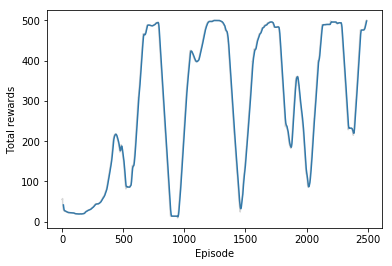

In [29]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

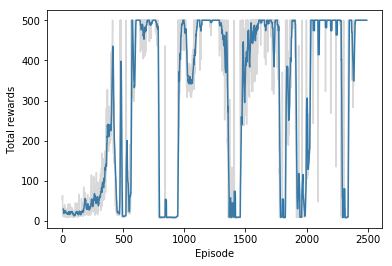

In [30]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

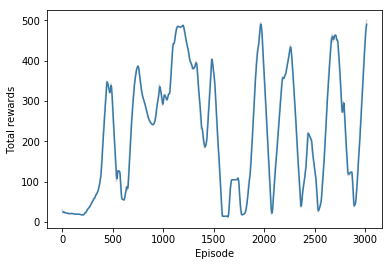

In [24]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

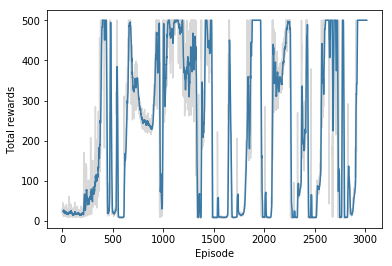

In [25]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

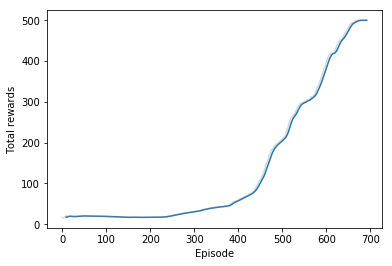

In [20]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

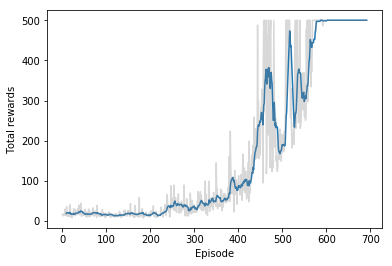

In [21]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Average losses')

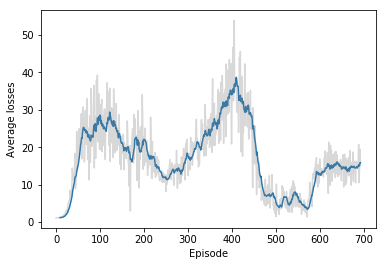

In [22]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

Text(0,0.5,'Total rewards')

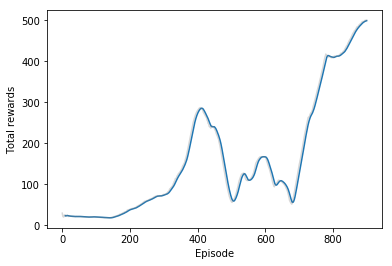

In [42]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

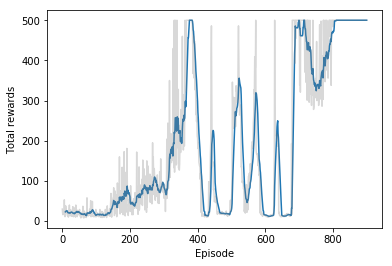

In [43]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

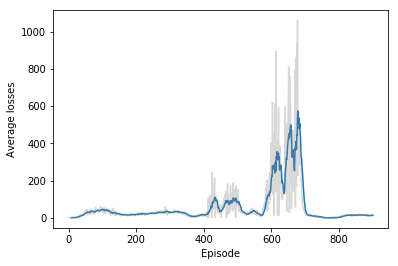

In [44]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [23]:
# Creating a gym env
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

# A training graph session
with tf.Session(graph=graph) as sess:
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model-qn.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
                
        # Closing the env
        print('total_reward: {}'.format(total_reward))
# Close the env at the end
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model-qn.ckpt


/home/arasdar/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.